# Pre-amble

In [4]:
# loading the required packages
import pandas as pd
import numpy as np
import datetime
import random
import re
import os
import plotnine
from plotnine import *

# for repeated printouts 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to custom displays of row-column df printouts
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Data import

Here, we'll load our analysis-ready sentencing data, and print out some of the basic information about the data:

In [6]:
# loading the analysis-ready dataset
intake_analysis = pd.read_csv('../Desktop/DS/intake_analysis.csv')

# then, we filter only for the black/white defendants 
intake_bw = intake_analysis[(intake_analysis.is_white == True) | 
                            (intake_analysis.is_black == True)].copy()

In [7]:
# printing out basic dataset info
# printing out the basic info
intake_bw.shape
intake_bw.dtypes

(369399, 36)

Unnamed: 0                   int64
CASE_ID                      int64
CASE_PARTICIPANT_ID          int64
RECEIVED_DATE               object
OFFENSE_CATEGORY            object
PARTICIPANT_STATUS          object
AGE_AT_INCIDENT            float64
RACE                        object
GENDER                      object
INCIDENT_CITY               object
INCIDENT_BEGIN_DATE         object
INCIDENT_END_DATE           object
LAW_ENFORCEMENT_AGENCY      object
LAW_ENFORCEMENT_UNIT        object
ARREST_DATE                 object
FELONY_REVIEW_DATE          object
FELONY_REVIEW_RESULT        object
UPDATE_OFFENSE_CATEGORY     object
is_black                    object
is_hispanic                   bool
is_white                    object
is_hisp                    float64
is_female                   object
age_cleaned                float64
felony_review_date          object
felony_review_year         float64
felony_review_month        float64
felony_review_day          float64
felony_review_ym    

In [10]:
# loading the analysis-ready dataset
sentencing_analysis = pd.read_csv('/Users/sierrasikorski/Desktop/ppol564_final_project_group4/sentencing_analysis.csv')

# we then filter for only black/white defendants
sentencing_bw = sentencing_analysis[(sentencing_analysis.is_black == True) | 
                                    (sentencing_analysis.is_white == True)].copy()

/var/folders/6k/pjvz2kxd4dz2dt0v3l5p885c0000gn/T/ipykernel_10688/2784658166.py:2: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.


In [11]:
# what's the shape of the data? 
print("Data shape: " + str(sentencing_analysis.shape))

Data shape: (186824, 76)


# Research questions:

Here, we aim to provide some preliminary tabulations on the following questions:

1. Does State Attorney Kim Foxx's entry lead to any changes in black-white incarceration probability?
2. Does State Attorney Kim Foxx's entry lead to any changes in black-white probability of probation?
3. Does State Attorney Kim Foxx's entry lead to any changes in black-white sentencing time?
4. How does the above dynamic differ by eligible/non-eligible cases?

Graphs:

In [6]:
import matplotlib.pyplot as plt

/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


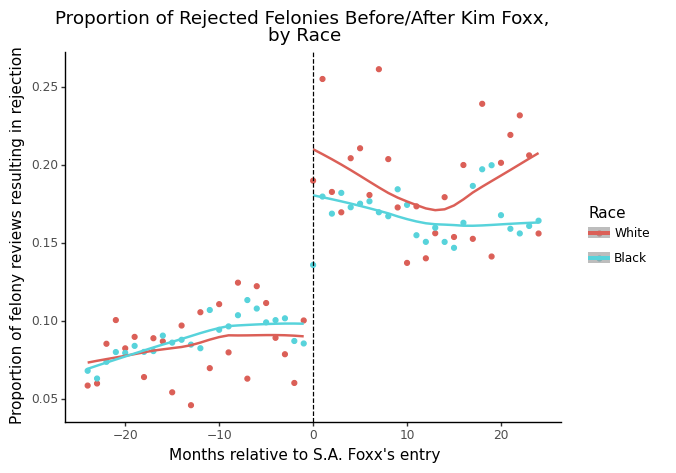

<ggplot: (8775261748462)>

In [14]:

# creating a by-race summary of felony review results
intake_bw_summary = intake_bw.groupby(['sa_timedelta', 'is_black'])['fr_is_rejected'].agg([('prop', 'mean'), 
                                                                                           ('n', 'sum')]).reset_index()

# filtering to specific timedelta
intake_bw_summary = intake_bw_summary[(intake_bw_summary.sa_timedelta >= -24) & 
                                      (intake_bw_summary.sa_timedelta <= 24)].copy()

# creating a by-race trend of felony review results
intake_bw_graph = (
    
    ggplot(intake_bw_summary, aes(x = 'sa_timedelta', y = 'prop', 
                                  group = 'is_black', color = 'is_black')) +
    geom_point() +
    geom_smooth(data = intake_bw_summary[intake_bw_summary.sa_timedelta < 0]) +
    geom_smooth(data = intake_bw_summary[intake_bw_summary.sa_timedelta >= 0]) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    labs(x = "Months relative to S.A. Foxx's entry", 
         y = 'Proportion of felony reviews resulting in rejection', 
         title = 'Proportion of Rejected Felonies Before/After Kim Foxx, \nby Race') +
    scale_color_discrete(labels = ['White', 'Black']) +
    theme_classic() +
    guides(color = guide_legend(title = 'Race'))
)

# plotting the graph 
intake_bw_graph


/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.p

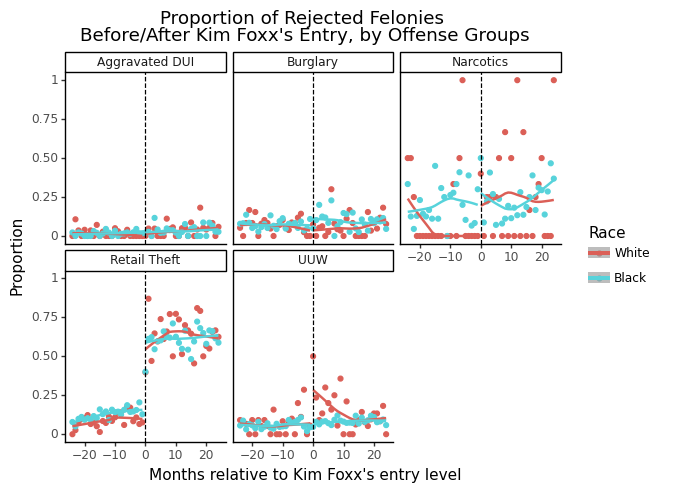

<ggplot: (8775224075373)>

In [15]:
# storing the top 5 offense category in a list
intake_top5_offense = list(intake_bw.UPDATE_OFFENSE_CATEGORY.value_counts().reset_index()['index'][0:5])

# filtering for top 5 offenses 
intake_bw_top5_summary = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY.isin(intake_top5_offense)].copy()

# renaming UUW 
intake_bw_top5_summary['UPDATE_OFFENSE_CATEGORY'] = intake_bw_top5_summary.UPDATE_OFFENSE_CATEGORY.str.replace('UUW - Unlawful Use of Weapon',
                                                                                                               'UUW')

# creating a by-race summary of felony review results
intake_bw_top5_summary = intake_bw_top5_summary.groupby(['sa_timedelta','UPDATE_OFFENSE_CATEGORY', 
                                                         'is_black'])['fr_is_rejected'].agg([('prop', 'mean'), 
                                                                                             ('n', 'sum')]).reset_index()

# filtering to specific timedelta
intake_bw_top5_summary = intake_bw_top5_summary[(intake_bw_top5_summary.sa_timedelta >= -24) & 
                                                (intake_bw_top5_summary.sa_timedelta <= 24)].copy()

intake_bw_top5_summary = intake_bw_top5_summary.sort_values(['UPDATE_OFFENSE_CATEGORY', 'is_black', 'sa_timedelta'])

# creating a by-race trend of felony review results
intake_bw_top5_graph = (
    
    ggplot(intake_bw_top5_summary, aes(x = 'sa_timedelta', y = 'prop', 
                                       group = 'is_black', color = 'is_black')) +
    geom_point() +
    geom_smooth(data = intake_bw_top5_summary[intake_bw_top5_summary.sa_timedelta < 0]) +
    geom_smooth(data = intake_bw_top5_summary[intake_bw_top5_summary.sa_timedelta >= 0]) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    labs(x = "Months relative to Kim Foxx's entry level", 
         y = 'Proportion', 
         title = "Proportion of Rejected Felonies \nBefore/After Kim Foxx's Entry, by Offense Groups") +
    scale_color_discrete(labels = ['White', 'Black']) +
    facet_wrap('UPDATE_OFFENSE_CATEGORY') +
    theme_classic() +
    guides(color = guide_legend(title = 'Race'))
)

# plotting the graph 
intake_bw_top5_graph


/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


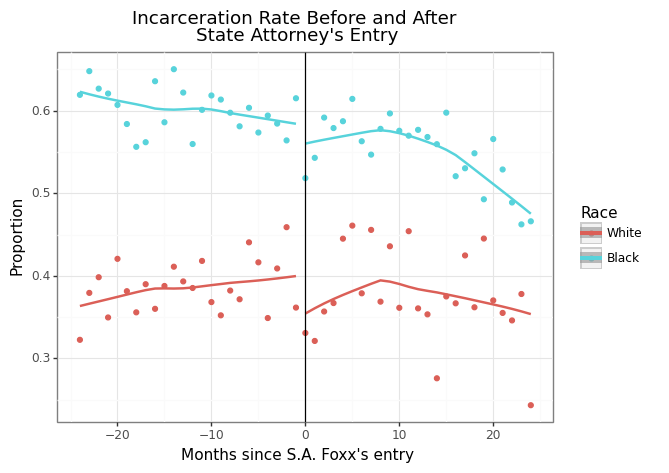

<ggplot: (8775331350007)>

In [16]:
# producing a by-race summary of incarceration proportion
incarc_bw_summary = sentencing_bw.groupby(['sa_timedelta', 'is_black'])['is_incarcerated'].agg([('prop', 'mean'), ('n', 'size')]).reset_index()

# filtering to specific timedelta
incarc_bw_summary = incarc_bw_summary[(incarc_bw_summary.sa_timedelta >= -24) & 
                                      (incarc_bw_summary.sa_timedelta <= 24)].copy()

# creating a time trend graph, by race
incarc_bw_graph = (
    ggplot(incarc_bw_summary, aes(x = 'sa_timedelta', y = 'prop', color = 'is_black')) + 
    geom_point() + 
    geom_smooth(data = incarc_bw_summary[incarc_bw_summary['sa_timedelta'] < 0]) +
    geom_smooth(data = incarc_bw_summary[incarc_bw_summary['sa_timedelta'] >= 0]) +
    theme_bw() + 
    labs(x = "Months since S.A. Foxx's entry", 
         y = "Proportion", 
         title = "Incarceration Rate Before and After \nState Attorney's Entry") +
    scale_color_discrete(labels = ['White', 'Black']) + 
    guides(color = guide_legend(title = 'Race')) + 
    geom_vline(xintercept = 0)
)

# showing the plot
incarc_bw_graph


/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.p

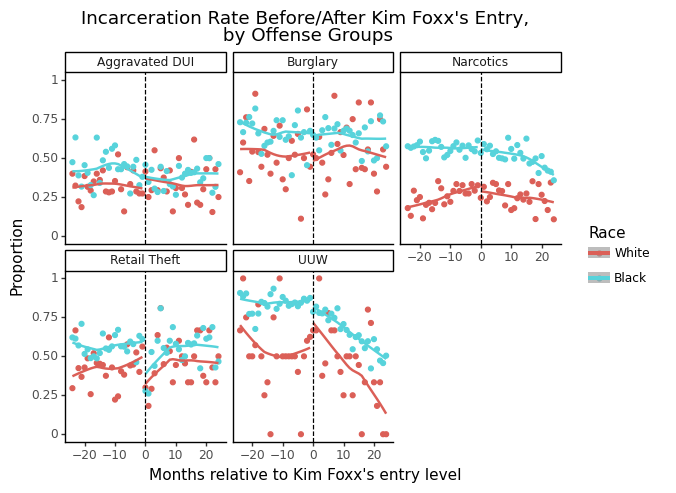

<ggplot: (8775346362365)>

In [17]:
# storing the top 5 offense category in a list
incarc_top5_offense = list(sentencing_bw.UPDATED_OFFENSE_CATEGORY.value_counts().reset_index()['index'][0:5])

# filtering for top 5 offenses 
incarc_bw_top5_summary = sentencing_bw[sentencing_bw.UPDATED_OFFENSE_CATEGORY.isin(incarc_top5_offense)].copy()

# renaming UUW 
incarc_bw_top5_summary['UPDATED_OFFENSE_CATEGORY'] = incarc_bw_top5_summary.UPDATED_OFFENSE_CATEGORY.str.replace('UUW - Unlawful Use of Weapon',
                                                                                                                 'UUW')

# creating a by-race summary of felony review results
incarc_bw_top5_summary = incarc_bw_top5_summary.groupby(['sa_timedelta','UPDATED_OFFENSE_CATEGORY', 
                                                         'is_black'])['is_incarcerated'].agg([('prop', 'mean'), 
                                                                                             ('n', 'sum')]).reset_index()

# filtering to specific timedelta
incarc_bw_top5_summary = incarc_bw_top5_summary[(incarc_bw_top5_summary.sa_timedelta >= -24) & 
                                                (incarc_bw_top5_summary.sa_timedelta <= 24)].copy()

incarc_bw_top5_summary = incarc_bw_top5_summary.sort_values(['UPDATED_OFFENSE_CATEGORY', 'is_black', 'sa_timedelta'])

# creating a by-race trend of felony review results
incarc_bw_top5_graph = (
    
    ggplot(incarc_bw_top5_summary, aes(x = 'sa_timedelta', y = 'prop', 
                                       group = 'is_black', color = 'is_black')) +
    geom_point() +
    geom_smooth(data = incarc_bw_top5_summary[incarc_bw_top5_summary.sa_timedelta < 0]) +
    geom_smooth(data = incarc_bw_top5_summary[incarc_bw_top5_summary.sa_timedelta >= 0]) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    labs(x = "Months relative to Kim Foxx's entry level", 
         y = 'Proportion', 
         title = "Incarceration Rate Before/After Kim Foxx's Entry,\n by Offense Groups") +
    scale_color_discrete(labels = ['White', 'Black']) +
    facet_wrap('UPDATED_OFFENSE_CATEGORY') +
    theme_classic() +
    guides(color = guide_legend(title = 'Race'))
)

# plotting the graph 
incarc_bw_top5_graph


/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


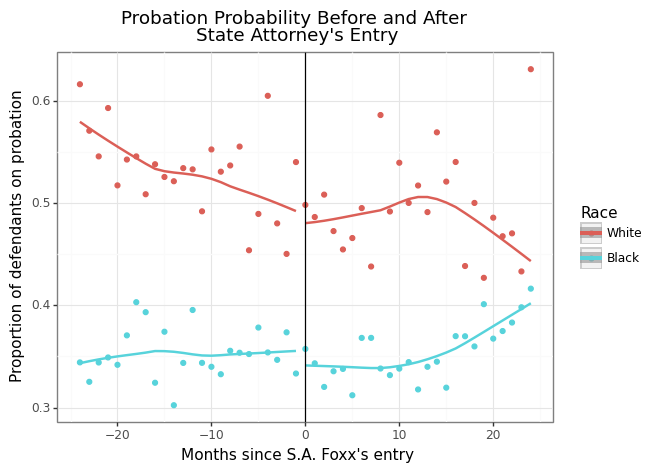

<ggplot: (8775261756290)>

In [18]:
# producing a by-race summary of probation proportion
sentencing_bw_summary = sentencing_bw.groupby(['sa_timedelta', 'is_black'])['is_on_probation'].agg([('prop', 'mean'), ('n', 'size')]).reset_index()

# filtering to specific timedelta
sentencing_bw_summary = sentencing_bw_summary[(sentencing_bw_summary.sa_timedelta >= -24) & 
                                              (sentencing_bw_summary.sa_timedelta <= 24)].copy()

# creating a time trend graph, by race
probation_gap_bw = (
    ggplot(sentencing_bw_summary, aes(x = 'sa_timedelta', y = 'prop', color = 'is_black')) + 
    geom_point() + 
    geom_smooth(data = sentencing_bw_summary[sentencing_bw_summary['sa_timedelta'] < 0]) +
    geom_smooth(data = sentencing_bw_summary[sentencing_bw_summary['sa_timedelta'] >= 0]) +
    theme_bw() + 
    labs(x = "Months since S.A. Foxx's entry", 
         y = "Proportion of defendants on probation", 
         title = "Probation Probability Before and After \nState Attorney's Entry") +
    scale_color_discrete(labels = ['White', 'Black']) + 
    guides(color = guide_legend(title = 'Race')) + 
    geom_vline(xintercept = 0)
)

# showing the plot
probation_gap_bw

/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


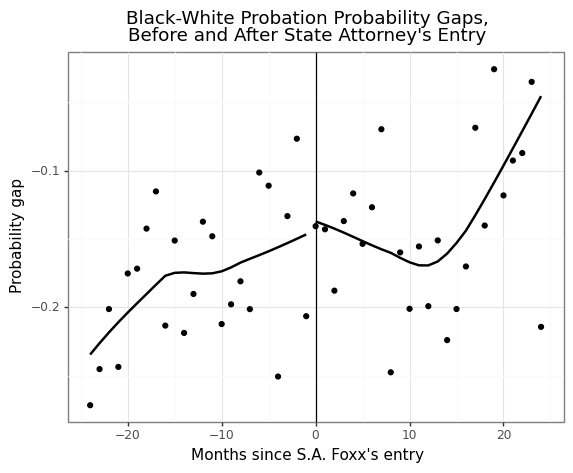

<ggplot: (8775346031857)>

In [19]:
# producing a by-race summary of probation proportion
sentencing_bw_summary = sentencing_bw.groupby(['sa_timedelta', 'is_black'])['is_on_probation'].agg([('prop', 'mean'), ('n', 'size')]).reset_index()

# filtering to specific timedelta
sentencing_bw_summary = sentencing_bw_summary[(sentencing_bw_summary.sa_timedelta >= -24) & 
                                              (sentencing_bw_summary.sa_timedelta <= 24)].copy()

# preparing the wide data
sentencing_bw_summary = pd.pivot(sentencing_bw_summary, index=['sa_timedelta'], columns='is_black', values = ['prop', 'n']).reset_index()
new_names = ['sa_timedelta', 'prop_white', 'prop_black', 'n_white', 'n_black']
sentencing_bw_summary.columns = new_names
sentencing_bw_summary['prop_bw_gap'] = sentencing_bw_summary['prop_black'] - sentencing_bw_summary['prop_white'] 

# plotting
probation_gap_bw2 = (
    ggplot(sentencing_bw_summary, aes(x = 'sa_timedelta', y = 'prop_bw_gap')) + 
    geom_point() + 
    geom_smooth(data = sentencing_bw_summary[sentencing_bw_summary['sa_timedelta'] < 0]) +
    geom_smooth(data = sentencing_bw_summary[sentencing_bw_summary['sa_timedelta'] >= 0]) +
    theme_bw() + 
    labs(x = "Months since S.A. Foxx's entry", 
         y = "Probability gap", 
         title = "Black-White Probation Probability Gaps,\nBefore and After State Attorney's Entry") +
    scale_color_discrete(labels = ['White', 'Black']) + 
    guides(color = guide_legend(title = 'Race')) + 
    geom_vline(xintercept = 0)
)

# showing the plot
probation_gap_bw2


/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.p

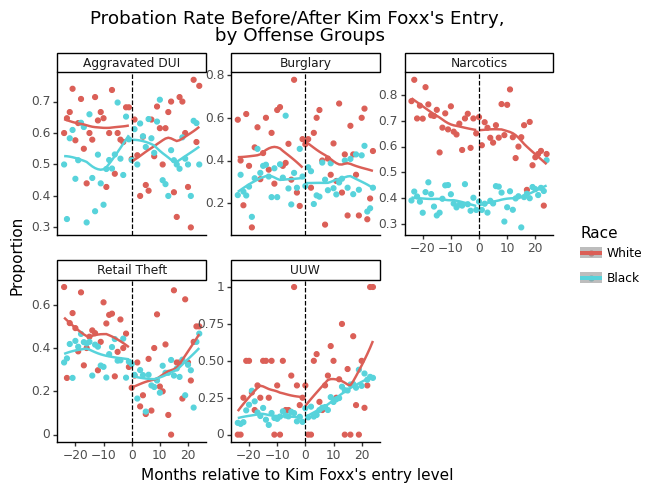

<ggplot: (8775224820345)>

In [20]:
# filtering for top 5 offenses 
prob_bw_top5_summary = sentencing_bw[sentencing_bw.UPDATED_OFFENSE_CATEGORY.isin(incarc_top5_offense)].copy()

# renaming UUW 
prob_bw_top5_summary['UPDATED_OFFENSE_CATEGORY'] = prob_bw_top5_summary.UPDATED_OFFENSE_CATEGORY.str.replace('UUW - Unlawful Use of Weapon',
                                                                                                             'UUW')

# # creating a by-race summary of felony review results
prob_bw_top5_summary = prob_bw_top5_summary.groupby(['sa_timedelta','UPDATED_OFFENSE_CATEGORY', 
                                                     'is_black'])['is_on_probation'].agg([('prop', 'mean'), 
                                                                                          ('n', 'sum')]).reset_index()

# filtering to specific timedelta
prob_bw_top5_summary = prob_bw_top5_summary[(prob_bw_top5_summary.sa_timedelta >= -24) & 
                                            (prob_bw_top5_summary.sa_timedelta <= 24)].copy()

prob_bw_top5_summary = prob_bw_top5_summary.sort_values(['UPDATED_OFFENSE_CATEGORY', 'is_black', 'sa_timedelta'])

# creating a by-race trend of felony review results
prob_bw_top5_graph = (
    
    ggplot(prob_bw_top5_summary, aes(x = 'sa_timedelta', y = 'prop', 
                                     group = 'is_black', color = 'is_black')) +
    geom_point() +
    geom_smooth(data = prob_bw_top5_summary[prob_bw_top5_summary.sa_timedelta < 0]) +
    geom_smooth(data = prob_bw_top5_summary[prob_bw_top5_summary.sa_timedelta >= 0]) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    labs(x = "Months relative to Kim Foxx's entry level", 
         y = 'Proportion', 
         title = "Probation Rate Before/After Kim Foxx's Entry,\n by Offense Groups") +
    scale_color_discrete(labels = ['White', 'Black']) +
    facet_wrap('UPDATED_OFFENSE_CATEGORY', scales = "free_y") +
    theme_classic() +
    theme(panel_spacing=.25) +
    guides(color = guide_legend(title = 'Race'))
)

# plotting the graph 
prob_bw_top5_graph

/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


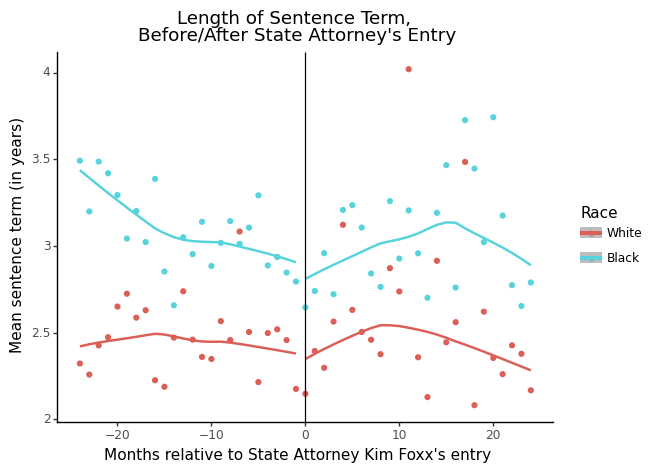

<ggplot: (8775273196409)>

In [42]:
# group by time periods 
sentence_time_summary = sentencing_bw.groupby(['sa_timedelta', 'is_black'])['sentencing_term_y'].agg([('mean_sentence', 'mean'), 
                                                                                                      ('median_sentence', 'median'), 
                                                                                                      ('n','size')]).reset_index()

# filtering to certain bandwidth
sentence_time_summary = sentence_time_summary[(sentence_time_summary.sa_timedelta >= -24) & 
                                              (sentence_time_summary.sa_timedelta <= 24)]

# plotting the results
sentencing_term_bw = (
    ggplot(sentence_time_summary, aes(x = "sa_timedelta", y = "mean_sentence", color = "is_black")) +
    geom_point() +
    geom_smooth(data = sentence_time_summary[sentence_time_summary.sa_timedelta < 0]) +
    geom_smooth(data = sentence_time_summary[sentence_time_summary.sa_timedelta >= 0]) +
    geom_vline(aes(xintercept = 0)) +
    labs(x = "Months relative to State Attorney Kim Foxx's entry", 
         y = "Mean sentence term (in years)", 
         title = "Length of Sentence Term, \nBefore/After State Attorney's Entry") +
    scale_color_discrete(labels = ['White', 'Black']) +
    guides(color = guide_legend(title = "Race")) +
    theme_classic()
)

# showing the plot
sentencing_term_bw

/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.p

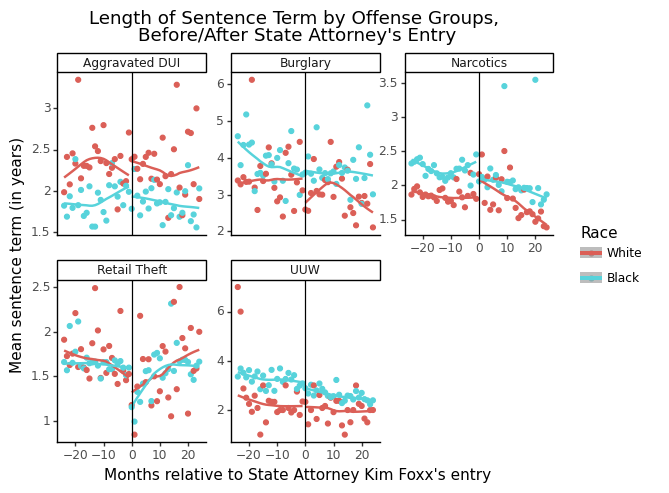

<ggplot: (8775262718928)>

In [22]:
# creating by-group summary of sentencing term 
sentencing_time_summary_byoff = sentencing_bw.groupby(['sa_timedelta', 'is_black', 
                                                       'UPDATED_OFFENSE_CATEGORY'])['sentencing_term_y'].agg([('mean_sentence', 'mean'), 
                                                                                                              ('n', 'size')]).reset_index()

# filtering the summary dataset 
sentencing_time_summary_byoff = sentencing_time_summary_byoff[(sentencing_time_summary_byoff.UPDATED_OFFENSE_CATEGORY.isin(incarc_top5_offense)) &
                                                              (sentencing_time_summary_byoff.sa_timedelta >= -24) & 
                                                              (sentencing_time_summary_byoff.sa_timedelta <= 24)].copy()

# renaming UUW 
sentencing_time_summary_byoff['UPDATED_OFFENSE_CATEGORY'] = sentencing_time_summary_byoff.UPDATED_OFFENSE_CATEGORY.str.replace('UUW - Unlawful Use of Weapon', 
                                                                                                                               'UUW')


# creating the viz 
sentencing_term_bw2 = (
    ggplot(sentencing_time_summary_byoff, aes(x = "sa_timedelta", y = 'mean_sentence', color = "is_black")) +
    geom_point() +
    geom_smooth(data = sentencing_time_summary_byoff[sentencing_time_summary_byoff.sa_timedelta < 0]) +
    geom_smooth(data = sentencing_time_summary_byoff[sentencing_time_summary_byoff.sa_timedelta >= 0]) +
    geom_vline(aes(xintercept = 0)) +
    labs(x = "Months relative to State Attorney Kim Foxx's entry", 
         y = "Mean sentence term (in years)", 
         title = "Length of Sentence Term by Offense Groups, \nBefore/After State Attorney's Entry") +
    scale_color_discrete(labels = ['White', 'Black']) +
    facet_wrap("UPDATED_OFFENSE_CATEGORY", scales = "free_y") +
    theme_classic() +
    theme(panel_spacing=.25) +
    guides(color = guide_legend(title = "Race"))
)

# showing the plot
sentencing_term_bw2


# How does State Attorney Foxx’s entry effect vary over time, and across several key characteristics that include, but are not limited to, crime types, defendant’s gender, age group and/or judge gender?

/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.p

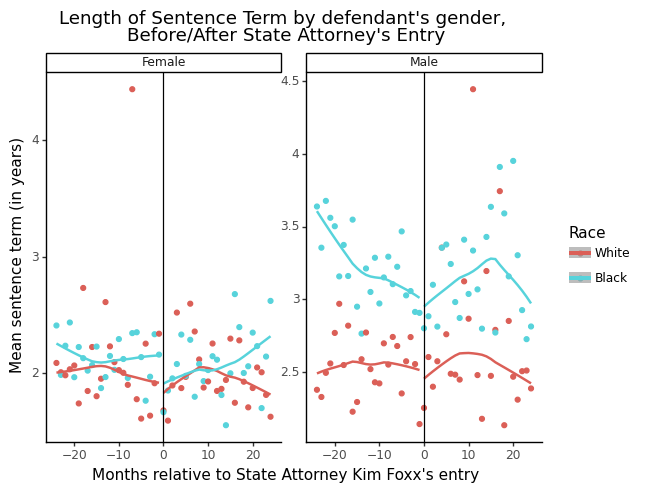

<ggplot: (8775227999037)>

In [71]:
#By gender 

# creating by-group summary of sentencing term 
sentencing_gender_summary_byoff = sentencing_bw.groupby(['sa_timedelta', 'is_black', 
                                                       'GENDER'])['sentencing_term_y'].agg([('mean_sentence', 'mean'), 
                                                                                                              ('n', 'size')]).reset_index()
# filtering the summary dataset 
sentencing_gender_summary_byoff = sentencing_gender_summary_byoff[(sentencing_gender_summary_byoff.sa_timedelta >= -24) & 
                                                              (sentencing_gender_summary_byoff.sa_timedelta <= 24) &
                                                            ((sentencing_gender_summary_byoff.GENDER == "Male") | 
                                                             (sentencing_gender_summary_byoff.GENDER == "Female"))].copy()

# creating the viz 
sentencing_term_bw2 = (
    ggplot(sentencing_gender_summary_byoff, aes(x = "sa_timedelta", y = 'mean_sentence', color = "is_black")) +
    geom_point() +
    geom_smooth(data = sentencing_gender_summary_byoff[sentencing_gender_summary_byoff.sa_timedelta < 0]) +
    geom_smooth(data = sentencing_gender_summary_byoff[sentencing_gender_summary_byoff.sa_timedelta >= 0]) +
    geom_vline(aes(xintercept = 0)) +
    labs(x = "Months relative to State Attorney Kim Foxx's entry", 
         y = "Mean sentence term (in years)", 
         title = "Length of Sentence Term by defendant's gender, \nBefore/After State Attorney's Entry") +
    scale_color_discrete(labels = ['White', 'Black']) +
    facet_wrap("GENDER", scales = "free_y") +
    theme_classic() +
    theme(panel_spacing=.25) +
    guides(color = guide_legend(title = "Race"))
)

# showing the plot
sentencing_term_bw2

In [145]:
sentencing_bw


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE_x,CHARGE_COUNT,DISPOSITION_DATE,DISPOSITION_CHARGED_CHAPTER,DISPOSITION_CHARGED_ACT,DISPOSITION_CHARGED_SECTION,DISPOSITION_CHARGED_CLASS,DISPOSITION_CHARGED_AOIC,CHARGE_DISPOSITION,CHARGE_DISPOSITION_REASON,SENTENCE_JUDGE,SENTENCE_COURT_NAME,SENTENCE_COURT_FACILITY,SENTENCE_PHASE,SENTENCE_DATE,SENTENCE_TYPE,CURRENT_SENTENCE_FLAG,COMMITMENT_TYPE,COMMITMENT_TERM,COMMITMENT_UNIT,LENGTH_OF_CASE_in_Days,AGE_AT_INCIDENT,RACE,GENDER,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY,is_black,is_hisp,is_white,is_female,age_cleaned,sentence_date,sentence_year,sentence_month,sentence_day,sentence_ym,sa_office_period,sa_timedelta,sa_timedelta_days,BRA_period,BRA_timedelta,BRA_timedelta_days,sentencing_num,sentencing_term_d,sentencing_term_y,is_incarcerated,is_on_probation,regrouped_offense,eligible_offense,DISPOSITION_CHARGED_OFFENSE_TITLE_y,uccs_code,probability,mfj_code,ncrp_code,ncic_code,nibrs_code,charge_desc,offense_category_code,offense_category_desc,offense_type_code,offense_type_desc,judge_fname
0,198055620664,85937621020,08/15/1984 12:00:00 AM,PROMIS Conversion,True,1242194578090,151097726688,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,38,-,9-1(a)(1),X,0000001606,Plea Of Guilty,NaN,Clayton Jay Crane,District 6 - Markham,Markham Courthouse,Amended/Corrected Sentencing,10/16/2014 12:00:00 AM,Prison,True,Illinois Department of Corrections,62.0,Year(s),10982.0,27.0,Black,Male,NaN,08/09/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,08/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,09/21/1984 12:00:00 AM,PROMIS Conversion,True,False,False,0.0,27.0,2014-10-16,2014,10,16,2014-10,False,-26,-777,False,-32,-970,62.0,22630.0,62.000000,True,False,PROMIS Conversion,False,FIRST DEGREE MURDER,1010,0.999990,10,010,NaN,09A,Murder,1,Murder,1,Violent,Clayton
1,198452967058,79292385441,08/23/1984 12:00:00 AM,PROMIS Conversion,True,1249137148269,151678615480,FIRST DEGREE MURDER,1,08/06/2014 12:00:00 AM,38,-,9-1(a)(1),X,0000001606,Verdict Guilty,NaN,Thomas V Gainer,District 1 - Chicago,26TH Street,Resentenced,08/06/2014 12:00:00 AM,Prison,True,Illinois Department of Corrections,1.0,Natural Life,NaN,30.0,Black,Male,NaN,02/10/1983 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,02/10/1983 12:00:00 AM,NaN,NaN,NaN,PROMIS Conversion,True,False,False,0.0,30.0,2014-08-06,2014,8,6,2014-08,False,-28,-848,False,-34,-1041,1.0,25550.0,70.000000,True,False,PROMIS Conversion,False,FIRST DEGREE MURDER,1010,0.999990,10,010,NaN,09A,Murder,1,Murder,1,Violent,Thomas
3,205272720716,106314583182,01/31/2001 12:00:00 AM,PROMIS Conversion,True,1325561059713,374900949858,POSS AMT CON SUB EXCEPT (A)/(D),1,09/10/2012 12:00:00 AM,720-570\402(C),NaN,NaN,4,0005101110,Plea Of Guilty,NaN,William J Kunkle,District 5 - Bridgeview,Bridgeview Courthouse,Original Sentencing,09/10/2012 12:00:00 AM,Probation,True,710/410 Probation,2.0,Year(s),NaN,33.0,Black,Female,NaN,01/30/2001 12:00:00 AM,NaN,C P D AREA 2 DIST 4,NaN,01/30/2001 02:10:00 AM,NaN,NaN,NaN,PROMIS Conversion,True,False,False,1.0,33.0,2012-09-10,2012,9,10,2012-09,False,-51,-1543,False,-57,-1736,2.0,730.0,2.000000,False,True,PROMIS Conversion,True,POSS AMT CON SUB EXCEPT (A)/(D),3080,0.634869,250,370,3590;3591;3592;3593;3594;3595,NaN,"Distribution, Drug Unspecified",42,Distribution - drug unspecified,3,Drug,William
4,205411772533,106247326235,02/06/2001 12:00:00 AM,PROMIS Conversion,True,1326510640104,220665098379,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,1,09/19/2014 12:00:00 AM,625-5\11-501(C-1)1,NaN,NaN,4,0000012480,Plea Of Guilty,NaN,Timothy Joseph Joyce,District 1 - Chicago,PROMIS,Original Sentencing,09/19/2014 12:00:00 AM,Probation,True,Probation,2.0,Year(s),NaN,49.0,White,Male,NaN,01/14/2001 12:00:00 AM,NaN,C P D AREA 5 DIST 17,Na

In [56]:
!pip install gender_guesser


     |████████████████████████████████| 379 kB 1.9 MB/s eta 0:00:01


In [64]:

sentencing_bw['judge_fname'] = sentencing_bw.SENTENCE_JUDGE.str.split(" ").str[0]
sentencing_bw[['SENTENCE_JUDGE', 'judge_fname']].head()

unique_names = sentencing_bw.judge_fname.unique()
"""Originally there were {} rows; only {} unique first names""".format(sentencing_bw.shape[0],
                                                                      len(unique_names))


,SENTENCE_JUDGE,judge_fname
0,Clayton Jay Crane,Clayton
1,Thomas V Gainer,Thomas
3,William J Kunkle,William
4,Timothy Joseph Joyce,Timothy
5,Steven J Goebel,Steven


'Originally there were 150245 rows; only 189 unique first names'

In [65]:
import gender_guesser.detector as gender
d = gender.Detector()
guess_gender = [d.get_gender(one_name) for one_name in unique_names]
names_wgender = pd.DataFrame({'judge_fname': unique_names, 'gender_guess': guess_gender})
names_wgender.sample(n = 5)

,judge_fname,gender_guess
184,Marsha,female
59,Laura,female
130,Ketki,unknown
1,Thomas,male
166,Mohammed,male


In [67]:
sentencing_wjudge = pd.merge(sentencing_bw, names_wgender,
                           on = 'judge_fname',
                           how = 'left')

/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/sierrasikorski/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.p

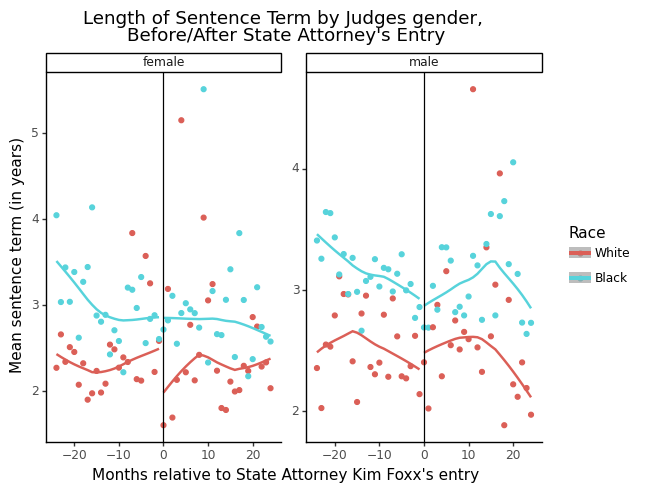

<ggplot: (8775277371140)>

In [95]:
# creating by-group summary of sentencing term 
sentencing_judge = sentencing_wjudge.groupby(['sa_timedelta', 'is_black', 
                                                       'gender_guess'])['sentencing_term_y'].agg([('mean_sentence', 'mean'), 
                                                                                                              ('n', 'size')]).reset_index()

# filtering the summary dataset 
sentencing_judge = sentencing_judge[(sentencing_judge.sa_timedelta >= -24) & 
                                                              (sentencing_judge.sa_timedelta <= 24) &
                                               ((sentencing_judge.gender_guess == "male")|
                                                (sentencing_judge.gender_guess == "female"))].copy()

# creating the viz 
sentencing_term_bw2 = (
    ggplot(sentencing_judge, aes(x = "sa_timedelta", y = 'mean_sentence', color = "is_black")) +
    geom_point() +
    geom_smooth(data = sentencing_judge[sentencing_judge.sa_timedelta < 0]) +
    geom_smooth(data = sentencing_judge[sentencing_judge.sa_timedelta >= 0]) +
    geom_vline(aes(xintercept = 0)) +
    labs(x = "Months relative to State Attorney Kim Foxx's entry", 
         y = "Mean sentence term (in years)", 
         title = "Length of Sentence Term by Judges gender, \nBefore/After State Attorney's Entry") +
    scale_color_discrete(labels = ['White', 'Black']) +
    facet_wrap("gender_guess", scales = "free_y") +
    theme_classic() +
    theme(panel_spacing=.25) +
    guides(color = guide_legend(title = "Race"))
)

# showing the plot
sentencing_term_bw2

# Regression

In [77]:
#!pip install rdrobust
from rdrobust import rdrobust, rdbwselect, rdplot

In [115]:
# defining a function to get a dataframe of the results (each containing three RD estimates:
# conventional, bias-corrected, and robust)
def rd_regress(yvar, xvar, sample_type):
    result = rdrobust(y = yvar, x = xvar, all = True)

    # initializing the dataframe
    result_df = result.coef

    # merging with other columns to complete the df 
    result_df = result_df.merge(result.se, left_index = True, right_index = True)
    result_df = result_df.merge(result.t, left_index = True, right_index = True)
    result_df = result_df.merge(result.pv, left_index = True, right_index = True)
    result_df = result_df.merge(result.ci, left_index = True, right_index = True)
    result_df['obs_left'] = result.N[0]
    result_df['obs_right'] = result.N[1]
    result_df['bandwidth_days'] = result.bws.loc['h'].values[0]
    result_df['outcome_var'] = yvar.name
    result_df['sample_type'] = sample_type

    # returning the result_df 
    return result_df

In [116]:
# next, we define a function to create RD plot
def rd_plot(yvar, xvar, ytitle, xtitle, title):
    
    # running the rd estimation
    result = rdrobust(y = yvar, x = xvar)
    
    # defining the group subset
    h_l, h_r = result.bws.loc['h', :].values
    subset = ((-h_l <= xvar) & (xvar <= h_r)).values

    # plotting the result
    rd_plot = rdplot(y = yvar, 
                     x = xvar, 
                     subset = subset, 
                     title = title, 
                     x_label = xtitle, 
                     y_label = ytitle)
    return rd_plot

In [117]:
gender_male = sentencing_bw[sentencing_bw['is_female'] == 0]
gender_male
gender_female = sentencing_bw[sentencing_bw['is_female'] == 1]

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE_x,CHARGE_COUNT,DISPOSITION_DATE,DISPOSITION_CHARGED_CHAPTER,DISPOSITION_CHARGED_ACT,DISPOSITION_CHARGED_SECTION,DISPOSITION_CHARGED_CLASS,DISPOSITION_CHARGED_AOIC,CHARGE_DISPOSITION,CHARGE_DISPOSITION_REASON,SENTENCE_JUDGE,SENTENCE_COURT_NAME,SENTENCE_COURT_FACILITY,SENTENCE_PHASE,SENTENCE_DATE,SENTENCE_TYPE,CURRENT_SENTENCE_FLAG,COMMITMENT_TYPE,COMMITMENT_TERM,COMMITMENT_UNIT,LENGTH_OF_CASE_in_Days,AGE_AT_INCIDENT,RACE,GENDER,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY,is_black,is_hisp,is_white,is_female,age_cleaned,sentence_date,sentence_year,sentence_month,sentence_day,sentence_ym,sa_office_period,sa_timedelta,sa_timedelta_days,BRA_period,BRA_timedelta,BRA_timedelta_days,sentencing_num,sentencing_term_d,sentencing_term_y,is_incarcerated,is_on_probation,regrouped_offense,eligible_offense,DISPOSITION_CHARGED_OFFENSE_TITLE_y,uccs_code,probability,mfj_code,ncrp_code,ncic_code,nibrs_code,charge_desc,offense_category_code,offense_category_desc,offense_type_code,offense_type_desc,judge_fname
0,198055620664,85937621020,08/15/1984 12:00:00 AM,PROMIS Conversion,True,1242194578090,151097726688,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,38,-,9-1(a)(1),X,0000001606,Plea Of Guilty,NaN,Clayton Jay Crane,District 6 - Markham,Markham Courthouse,Amended/Corrected Sentencing,10/16/2014 12:00:00 AM,Prison,True,Illinois Department of Corrections,62.0,Year(s),10982.0,27.0,Black,Male,NaN,08/09/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,08/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,09/21/1984 12:00:00 AM,PROMIS Conversion,True,False,False,0.0,27.0,2014-10-16,2014,10,16,2014-10,False,-26,-777,False,-32,-970,62.0,22630.0,62.000000,True,False,PROMIS Conversion,False,FIRST DEGREE MURDER,1010,0.999990,10,010,NaN,09A,Murder,1,Murder,1,Violent,Clayton
1,198452967058,79292385441,08/23/1984 12:00:00 AM,PROMIS Conversion,True,1249137148269,151678615480,FIRST DEGREE MURDER,1,08/06/2014 12:00:00 AM,38,-,9-1(a)(1),X,0000001606,Verdict Guilty,NaN,Thomas V Gainer,District 1 - Chicago,26TH Street,Resentenced,08/06/2014 12:00:00 AM,Prison,True,Illinois Department of Corrections,1.0,Natural Life,NaN,30.0,Black,Male,NaN,02/10/1983 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,02/10/1983 12:00:00 AM,NaN,NaN,NaN,PROMIS Conversion,True,False,False,0.0,30.0,2014-08-06,2014,8,6,2014-08,False,-28,-848,False,-34,-1041,1.0,25550.0,70.000000,True,False,PROMIS Conversion,False,FIRST DEGREE MURDER,1010,0.999990,10,010,NaN,09A,Murder,1,Murder,1,Violent,Thomas
4,205411772533,106247326235,02/06/2001 12:00:00 AM,PROMIS Conversion,True,1326510640104,220665098379,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,1,09/19/2014 12:00:00 AM,625-5\11-501(C-1)1,NaN,NaN,4,0000012480,Plea Of Guilty,NaN,Timothy Joseph Joyce,District 1 - Chicago,PROMIS,Original Sentencing,09/19/2014 12:00:00 AM,Probation,True,Probation,2.0,Year(s),NaN,49.0,White,Male,NaN,01/14/2001 12:00:00 AM,NaN,C P D AREA 5 DIST 17,NaN,01/14/2001 06:45:00 PM,NaN,NaN,NaN,PROMIS Conversion,False,False,True,0.0,49.0,2014-09-19,2014,9,19,2014-09,False,-27,-804,False,-33,-997,2.0,730.0,2.000000,False,True,PROMIS Conversion,True,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,4020,0.957017,350,565,5404,NaN,Driving Under the Influence of Alcohol,60,Driving Under the Influence,4,DUI Offense,Timothy
5,205885247855,108466528500,06/15/2001 12:00:00 AM,PROMIS Conversion,True,1353046960885,920238371999,AGGRAVATED CRIMINAL SEXUAL ASSAULT,1,05/03/2013 12:00:00 AM,720,5,12-14(b)(i),X,0011281,Nolle On Remand,NaN,Steven J Goebel,District 1 - Chicago,26TH Street,Remanded Sentencing,05/03/2013 12:00:00 AM,Prison,True,Illinois Department of Corrections,10.0,Year(s),NaN,NaN,Black,Male,NaN,06/14/2001 12:00:00 AM,NaN,C P D AREA 1 DIST 21,NaN,06/

In [118]:
gender_male_regression = rd_regress(yvar= gender_male.is_incarcerated, xvar= gender_male.sa_timedelta, sample_type= '1')


Mass points detected in the running variable.
Mass points detected in the running variable.


In [123]:
gender_male_regression

,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-0.043216,0.014954,-2.889952,0.003853,-0.072525,-0.013907,83421,46649,10.737266,is_incarcerated,1
Bias-Corrected,-0.048218,0.014954,-3.224460,0.001262,-0.077527,-0.018909,83421,46649,10.737266,is_incarcerated,1
Robust,-0.048218,0.016895,-2.853912,0.004318,-0.081333,-0.015104,83421,46649,10.737266,is_incarcerated,1


In [138]:
rd_female_gender= rd_regress(yvar= gender_female.is_incarcerated, xvar= gender_female.sa_timedelta, sample_type= '2')
rd_female_gender

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-0.080129,0.030848,-2.597591,0.009388,-0.140590,-0.019669,13309,6828,12.463037,is_incarcerated,2
Bias-Corrected,-0.088794,0.030848,-2.878465,0.003996,-0.149254,-0.028334,13309,6828,12.463037,is_incarcerated,2
Robust,-0.088794,0.036089,-2.460421,0.013877,-0.159526,-0.018061,13309,6828,12.463037,is_incarcerated,2


In [139]:
rd_total_gender=rd_regress(yvar= sentencing_bw.is_incarcerated, xvar= sentencing_bw.sa_timedelta, sample_type= '3')
rd_total_gender

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-0.058024,0.015051,-3.855062,0.000116,-0.087524,-0.028524,96749,53496,9.332441,is_incarcerated,3
Bias-Corrected,-0.063444,0.015051,-4.215211,0.000025,-0.092944,-0.033944,96749,53496,9.332441,is_incarcerated,3
Robust,-0.063444,0.016807,-3.774827,0.000160,-0.096386,-0.030503,96749,53496,9.332441,is_incarcerated,3


In [140]:
gender_results= pd.concat([gender_male_regression, rd_female_gender, rd_total_gender]).reset_index()

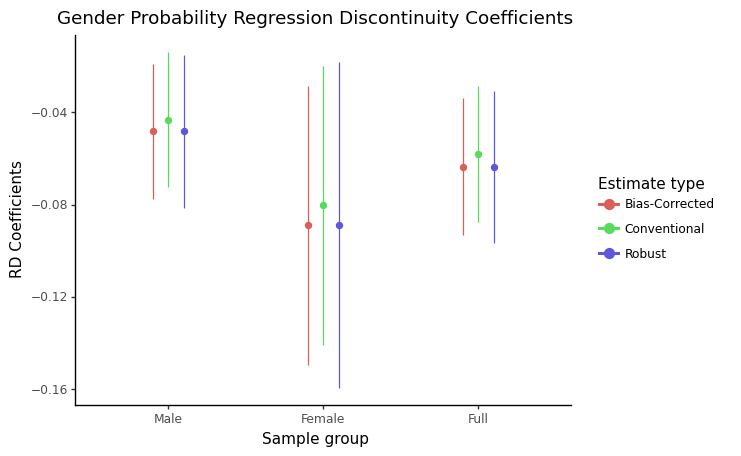

<ggplot: (8775359545486)>

In [151]:
rd_plot_gender = (
    ggplot(gender_results, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Gender Probability Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Male', 'Female', 'Full']) +
    theme_classic() +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_gender


# Probation Regression


In [135]:
male_probation = rd_regress(yvar= gender_male.is_on_probation, xvar= gender_male.sa_timedelta, sample_type= '1')
male_probation

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-0.018415,0.010860,-1.695612,0.089959,-0.039700,0.002871,83421,46649,18.522644,is_on_probation,1
Bias-Corrected,-0.015832,0.010860,-1.457768,0.144905,-0.037117,0.005454,83421,46649,18.522644,is_on_probation,1
Robust,-0.015832,0.012832,-1.233707,0.217312,-0.040983,0.009320,83421,46649,18.522644,is_on_probation,1


In [133]:
female_probation= rd_regress(yvar= gender_female.is_on_probation, xvar= gender_female.sa_timedelta, sample_type= '2')
female_probation 

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,0.002976,0.025932,0.114760,0.908635,-0.047849,0.053801,13309,6828,21.448111,is_on_probation,2
Bias-Corrected,0.013739,0.025932,0.529818,0.596238,-0.037086,0.064565,13309,6828,21.448111,is_on_probation,2
Robust,0.013739,0.029262,0.469517,0.638700,-0.043614,0.071092,13309,6828,21.448111,is_on_probation,2


In [134]:
total_probation= rd_regress(yvar= sentencing_bw.is_on_probation, xvar= sentencing_bw.sa_timedelta, sample_type= '3')
total_probation

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-0.013259,0.010842,-1.222928,0.221357,-0.034509,0.007991,96749,53496,16.849994,is_on_probation,3
Bias-Corrected,-0.009925,0.010842,-0.915445,0.359958,-0.031175,0.011325,96749,53496,16.849994,is_on_probation,3
Robust,-0.009925,0.012581,-0.788919,0.430160,-0.034583,0.014733,96749,53496,16.849994,is_on_probation,3


In [143]:
probation = pd.concat([male_probation, female_probation, total_probation]).reset_index()

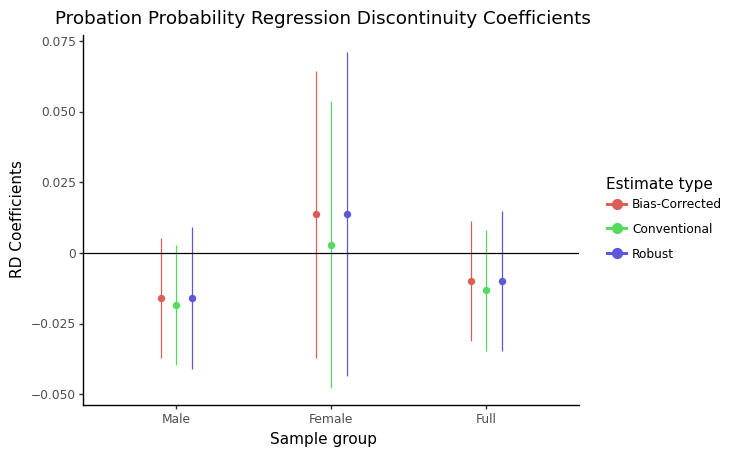

<ggplot: (8775312452301)>

In [183]:
rd_plot_gender_probation = (
    ggplot(probation, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +

    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Probation Probability Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Male', 'Female', 'Full']) +
    theme_classic() +
    geom_hline(aes(yintercept = 0)) +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_gender_probation

In [1]:
gender_male

NameError: name 'gender_male' is not defined

In [146]:
male_sentence= rd_regress(yvar= gender_male.sentencing_term_d, xvar= gender_male.sa_timedelta, sample_type= '1')
male_sentence

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-17.898542,37.027145,-0.483390,0.628819,-90.470412,54.673328,82497,46574,15.062289,sentencing_term_d,1
Bias-Corrected,-25.500762,37.027145,-0.688705,0.491009,-98.072633,47.071108,82497,46574,15.062289,sentencing_term_d,1
Robust,-25.500762,43.617057,-0.584651,0.558782,-110.988623,59.987098,82497,46574,15.062289,sentencing_term_d,1


In [148]:
female_sentence= rd_regress(yvar= gender_female.sentencing_term_d, xvar= gender_female.sa_timedelta, sample_type= '2')
female_sentence

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-88.462082,42.757070,-2.068946,0.038551,-172.264399,-4.659764,13293,6819,15.517686,sentencing_term_d,2
Bias-Corrected,-96.149090,42.757070,-2.248730,0.024530,-179.951408,-12.346773,13293,6819,15.517686,sentencing_term_d,2
Robust,-96.149090,51.105977,-1.881367,0.059922,-196.314964,4.016783,13293,6819,15.517686,sentencing_term_d,2


In [147]:
total_sentence= rd_regress(yvar= sentencing_bw.sentencing_term_d, xvar= sentencing_bw.sa_timedelta, sample_type= '3')
total_sentence

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-28.898867,32.680840,-0.884276,0.376547,-92.952137,35.154402,95809,53412,14.836373,sentencing_term_d,3
Bias-Corrected,-32.833896,32.680840,-1.004683,0.315049,-96.887165,31.219374,95809,53412,14.836373,sentencing_term_d,3
Robust,-32.833896,38.811651,-0.845980,0.397564,-108.903333,43.235542,95809,53412,14.836373,sentencing_term_d,3


In [149]:
sentence = pd.concat([male_sentence, female_sentence, total_sentence]).reset_index()

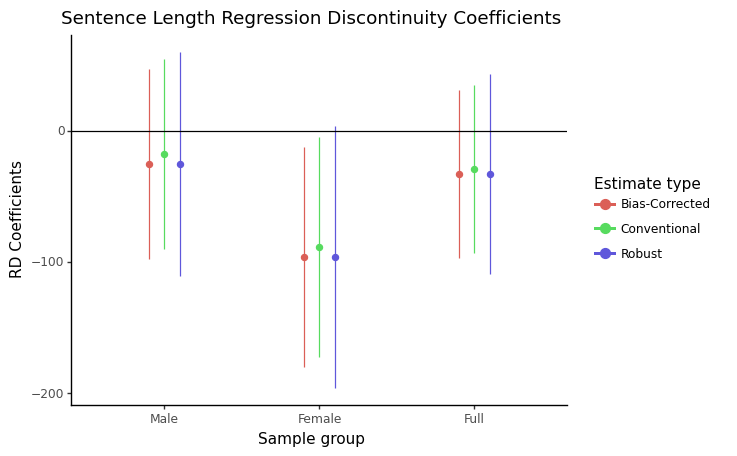

<ggplot: (8775329677475)>

In [184]:
rd_plot_gender_sentence = (
    ggplot(sentence, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Sentence Length Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Male', 'Female', 'Full']) +
    theme_classic() +
     geom_hline(aes(yintercept = 0)) +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_gender_sentence

# Top 5 offenses

In [154]:
# storing the top 5 offense category in a list
incarc_top5_offense = list(sentencing_bw.UPDATED_OFFENSE_CATEGORY.value_counts().reset_index()['index'][0:5])

# filtering for top 5 offenses 
incarc_bw_top5_summary = sentencing_bw[sentencing_bw.UPDATED_OFFENSE_CATEGORY.isin(incarc_top5_offense)].copy()

# renaming UUW 
incarc_bw_top5_summary['UPDATED_OFFENSE_CATEGORY'] = incarc_bw_top5_summary.UPDATED_OFFENSE_CATEGORY.str.replace('UUW - Unlawful Use of Weapon',
                                                                                                                 'UUW')

In [156]:
incarc_bw_top5_summary.UPDATED_OFFENSE_CATEGORY.unique()

array(['Aggravated DUI', 'UUW', 'Retail Theft', 'Burglary', 'Narcotics'],
      dtype=object)

In [158]:
dui_df= incarc_bw_top5_summary[incarc_bw_top5_summary['UPDATED_OFFENSE_CATEGORY']== "Aggravated DUI"]
uuw_df= incarc_bw_top5_summary[incarc_bw_top5_summary['UPDATED_OFFENSE_CATEGORY']== "UUW"]
theft_df= incarc_bw_top5_summary[incarc_bw_top5_summary['UPDATED_OFFENSE_CATEGORY']== "Retail Theft"]
burglary_df= incarc_bw_top5_summary[incarc_bw_top5_summary['UPDATED_OFFENSE_CATEGORY']== "Burglary"]
narcotics_df= incarc_bw_top5_summary[incarc_bw_top5_summary['UPDATED_OFFENSE_CATEGORY']== "Narcotics"]

In [159]:
top5_rd= rd_regress(yvar= incarc_bw_top5_summary.sentencing_term_d, 
                    xvar= incarc_bw_top5_summary.sa_timedelta, sample_type= '1')
top5_rd

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-84.894140,23.952179,-3.544318,0.000394,-131.839548,-37.948733,56694,30472,11.400387,sentencing_term_d,1
Bias-Corrected,-97.102628,23.952179,-4.054021,0.000050,-144.048035,-50.157220,56694,30472,11.400387,sentencing_term_d,1
Robust,-97.102628,27.640799,-3.513018,0.000443,-151.277599,-42.927657,56694,30472,11.400387,sentencing_term_d,1


In [160]:
dui_rd= rd_regress(yvar= dui_df.sentencing_term_d, 
                    xvar= dui_df.sa_timedelta, sample_type= '2')
dui_rd

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-5.564609,41.047219,-0.135566,0.892164,-86.015679,74.886462,4098,2692,17.712654,sentencing_term_d,2
Bias-Corrected,-4.526248,41.047219,-0.110269,0.912196,-84.977319,75.924823,4098,2692,17.712654,sentencing_term_d,2
Robust,-4.526248,49.587237,-0.091278,0.927271,-101.715447,92.662950,4098,2692,17.712654,sentencing_term_d,2


In [161]:
uuw_rd= rd_regress(yvar= uuw_df.sentencing_term_d, 
                    xvar= uuw_df.sa_timedelta, sample_type= '3')
uuw_rd

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-81.397137,65.756491,-1.237857,0.215769,-210.277491,47.483217,6516,8799,18.139866,sentencing_term_d,3
Bias-Corrected,-80.554494,65.756491,-1.225042,0.220559,-209.434848,48.325860,6516,8799,18.139866,sentencing_term_d,3
Robust,-80.554494,79.443064,-1.013990,0.310587,-236.260038,75.151050,6516,8799,18.139866,sentencing_term_d,3


In [162]:
theft_rd= rd_regress(yvar= theft_df.sentencing_term_d, 
                    xvar= theft_df.sa_timedelta, sample_type= '4')
theft_rd

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-170.600270,25.152326,-6.782684,1.179638e-11,-219.897923,-121.302616,9245,2428,14.392649,sentencing_term_d,4
Bias-Corrected,-179.742399,25.152326,-7.146154,8.924286e-13,-229.040053,-130.444746,9245,2428,14.392649,sentencing_term_d,4
Robust,-179.742399,28.462138,-6.315140,2.699163e-10,-235.527165,-123.957634,9245,2428,14.392649,sentencing_term_d,4


In [163]:
burglary_rd= rd_regress(yvar= burglary_df.sentencing_term_d, 
                    xvar= burglary_df.sa_timedelta, sample_type= '5')
burglary_rd

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,40.319787,60.232282,0.669405,0.503237,-77.733316,158.372889,5508,2988,25.777359,sentencing_term_d,5
Bias-Corrected,53.401717,60.232282,0.886596,0.375296,-64.651386,171.454819,5508,2988,25.777359,sentencing_term_d,5
Robust,53.401717,71.340720,0.748545,0.454132,-86.423524,193.226958,5508,2988,25.777359,sentencing_term_d,5


In [165]:
narcotics_rd= rd_regress(yvar= narcotics_df.sentencing_term_d, 
                    xvar= narcotics_df.sa_timedelta, sample_type= '6')
narcotics_rd

Mass points detected in the running variable.
Mass points detected in the running variable.


,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
Conventional,-51.073595,22.622506,-2.257645,0.023968,-95.412891,-6.734298,31327,13565,16.964622,sentencing_term_d,6
Bias-Corrected,-67.187064,22.622506,-2.969921,0.002979,-111.526361,-22.847768,31327,13565,16.964622,sentencing_term_d,6
Robust,-67.187064,27.337419,-2.457696,0.013983,-120.767422,-13.606707,31327,13565,16.964622,sentencing_term_d,6


In [180]:
top5_full = pd.concat([top5_rd, dui_rd, uuw_rd, theft_rd, burglary_rd, narcotics_rd]).reset_index()

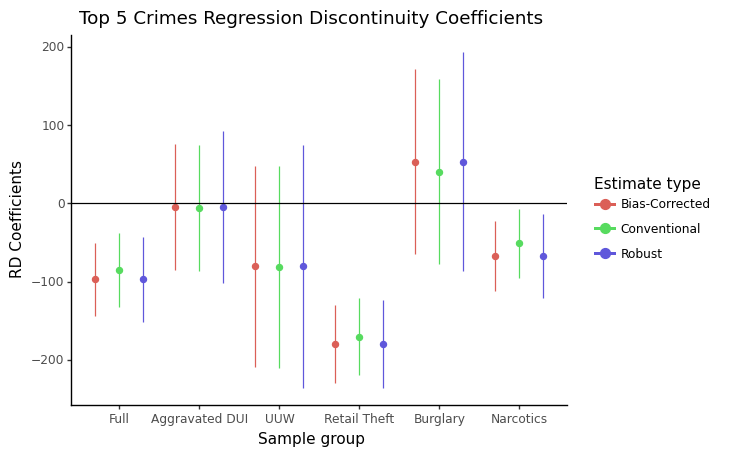

<ggplot: (8775328713141)>

In [185]:
rd_plot_top5 = (
    ggplot(top5_full, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .9)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Top 5 Crimes Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Full', 'Aggravated DUI', 'UUW', 'Retail Theft', 'Burglary', 'Narcotics']) +
    theme_classic() +
     geom_hline(aes(yintercept = 0)) +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_top5